# Retrieval-Augmented Generation

## Einführung

In diesem Notebook wird mit LangGraph ein Chatbot für die *Magpie* implementiert. LangGraph ist ein Framework, das auf LangChain basiert und speziell für zustandsbasierte, mehrstufige KI-Agenten in Form von Graphen entwickelt wurde.

LangGraph ermöglicht die Erstellung von komplexen Entscheidungsstrukturen und Workflows für KI-Agenten. Es unterstützt Schleifen, Verzweigungen und wiederkehrende Prozesse. Ein zentrales Element ist die Zustandsverwaltung, wodurch Agenten über längere Interaktionen hinweg Kontext behalten und aktualisieren können.

Der Chatbot unterscheidet sich im Vorgehen von einer *normalen* RAG: Während bei einer RAG üblicherweise Text generiert wird (die Anfrage durch einen User), der gegen eine Vektordatenbank durchsucht werden kann, besteht der Ansatz für strukturierte Daten darin, dass das LLM SQL-Abfragen schreibt und ausführt.

Der zu generierende Agent soll folgendermaßen vorgehen: 

1. Passende Variable für die Anfrage finden
   - Gehe in die Tabelle `variable`.
   - Suche in der Spalte `beschr`.
   - Nutze das entsprechende Retriever-Tool.
   - Bestimme die ID der passenden Variable.

2. Passende Reichweite für die Anfrage finden
   - Gehe in die Tabelle `reichweite`.
   - Suche in der Spalte `beschr`.
   - Nutze das entsprechende Retriever-Tool.
   - Bestimme die ID der passenden Reichweite.

3. Passende Werteinheit für die Anfrage finden
   - Gehe in die Tabelle `wert_einheit`.
   - Suche in der Spalte `beschr`.
   - Nutze das entsprechende Retriever-Tool.
   - Bestimme die ID der passenden Werteinheit.

4. Daten filtern und Antwort generieren
   - Gehe in die Tabelle `daten`.
   - Filtere die Daten nach den gefundenen IDs.
   - Gib die Antwort aus.

## Durchführung

### Arbeitspfad definieren

In einem ersten Schritt definieren wir unseren Arbeitspfad:

In [2]:
# Aktuelles Arbeitsverzeichnis ermitteln
import os
os.getcwd()
# Arbeitspfad Privatrechner:
os.chdir("c:/Users/mhu/Documents/gitHub/magpie_chatbot")
# os.chdir("c:/Users/Hueck/OneDrive/Dokumente/GitHub/magpie_langchain")

### LLM laden

In einem weiteren Schritt laden wir ein Large Language Modell (LLM). Das LLM wandelt die Anfrage des Users in eine SQL-Abfrage um und antwortet basierend auf den Ergebnissen der Abfrage in natürlicher Sprache. Das sich `Mistral`, `qwen2.5:32b` und  `llama3.1:8b-instruct-q4_0` nicht so leistungsfähig wie `gpt-4o-mini` im Kontext der Generierung der SQL-Abfragen erwiesen hat, wird vorerst mit einer OpenAI-API gearbeitet. Sie wird mit `load_dotenv()` im folgenden aus dem Environment geladen um auf `gpt-4o-mini` zugreifen zu können. Der Code importiert weiterhin die `ChatOpenAI`-Klasse aus dem Modul `langchain_openai`, welches die Nutzung von OpenAI-Modellen vereinfacht. Anschließend wird ein Objekt `llm` vom Typ `ChatOpenAI` erstellt, wobei das Modell `"o3-mini"` angegeben wird.

In [3]:
from dotenv import load_dotenv

# Lade Umgebungsvariablen aus der .env Datei
load_dotenv()

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

# from langchain_ollama import ChatOllama
# llm = ChatOllama(model="qwen2.5:32b", temperature=0)

### Tools genieren

Wir erstellen nun ein Set von standardisierten `tools`. Das `SQLDatabaseToolkit` umfasst in diesem Kontext Werkzeuge, die uns dabei unterstützen, SQL-Abfragen zu erstellen und auszuführen sowie die Syntax von SQL-Abfragen zu überprüfen. 

Es wird dafür eine Instanz von `SQLDatabase` erstellt, um Interaktionen mit der Datenbank zu ermöglichen. Nach der Einrichtung der Datenbank wird eine Instanz von `SQLDatabaseToolkit` erstellt, die zwei Argumente benötigt: die zuvor erstellte `db`-Instanz und die oben definierte `llm` (Sprachmodell)-Instanz (siehe oben). Das Toolkit nutzt das Sprachmodell für Aufgaben wie die Validierung von Abfragen.

Die Methode `get_tools` der `SQLDatabaseToolkit`-Instanz wird dann aufgerufen, um eine Liste der verfügbaren Werkzeuge im Toolkit abzurufen. Diese Werkzeuge umfassen Funktionen wie das Auflisten von Datenbanktabellen, das Abrufen von Schema-Informationen, das Ausführen von SQL-Abfragen und das Überprüfen der Korrektheit von SQL-Abfragen. Die letzte Zeile des Codes gibt die Liste der Werkzeuge aus, sodass der Benutzer die verfügbaren Werkzeuge und deren Beschreibungen einsehen kann.

In [46]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("duckdb:///data/magpie.db")

tables = db.run("SELECT name FROM sqlite_master WHERE type='table';")
print(tables)




[('antwort',), ('chart_options_rules',), ('daten',), ('datensatz_drittmittel_aggregiert',), ('datensatz_drittmittel_hochschule',), ('datensatz_fue_erhebung',), ('datensatz_hbr_report',), ('daten_frage',), ('daten_quelle',), ('daten_reichweite',), ('erhebung',), ('erhebung_frage',), ('erhebung_typ',), ('erklaerung',), ('erklaerung_link',), ('frage',), ('germany_choropleth_federal_states',), ('glossar',), ('kurse',), ('menge',), ('menge_zugehoerig',), ('middle_points_of_ger_federal_states',), ('mview_daten_beschr',), ('mview_daten_id',), ('mview_daten_reichweite_menge',), ('quelle',), ('reichweite',), ('reichweite_klasse',), ('reichweite_typ',), ('stichprobe',), ('studierende',), ('studierende_detailliert',), ('tabelle',), ('tag',), ('tag_link',), ('variable',), ('view_daten',), ('view_daten_beschr',), ('view_daten_beschr_string',), ('view_daten_detailed',), ('view_daten_id',), ('view_daten_id_string',), ('view_daten_link',), ('view_daten_reichweite_menge',), ('view_daten_struktur',), ('

c:\Users\mhu\AppData\Local\miniconda3\envs\chatbot_magpie\lib\site-packages\duckdb_engine\__init__.py:184: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


In [47]:
tables = db.run("SELECT name FROM sqlite_master WHERE type='table';")
print(tables)

[('antwort',), ('chart_options_rules',), ('daten',), ('datensatz_drittmittel_aggregiert',), ('datensatz_drittmittel_hochschule',), ('datensatz_fue_erhebung',), ('datensatz_hbr_report',), ('daten_frage',), ('daten_quelle',), ('daten_reichweite',), ('erhebung',), ('erhebung_frage',), ('erhebung_typ',), ('erklaerung',), ('erklaerung_link',), ('frage',), ('germany_choropleth_federal_states',), ('glossar',), ('kurse',), ('menge',), ('menge_zugehoerig',), ('middle_points_of_ger_federal_states',), ('mview_daten_beschr',), ('mview_daten_id',), ('mview_daten_reichweite_menge',), ('quelle',), ('reichweite',), ('reichweite_klasse',), ('reichweite_typ',), ('stichprobe',), ('studierende',), ('studierende_detailliert',), ('tabelle',), ('tag',), ('tag_link',), ('variable',), ('view_daten',), ('view_daten_beschr',), ('view_daten_beschr_string',), ('view_daten_detailed',), ('view_daten_id',), ('view_daten_id_string',), ('view_daten_link',), ('view_daten_reichweite_menge',), ('view_daten_struktur',), ('

In [48]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"Tool Name: {tool.name}")
    print(f"Description: {tool.description}")
    print("-" * 40)

Tool Name: sql_db_query
Description: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
----------------------------------------
Tool Name: sql_db_schema
Description: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
----------------------------------------
Tool Name: sql_db_list_tables
Description: Input is an empty string, output is a comma-separated list of tables in the database.
----------------------------------------
Tool Name: sql_db_query_checker
Description: Use this tool to double check if your query is

In [49]:
import pandas as pd
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("duckdb:///data/magpie.db")

query = "SELECT * FROM view_daten_reichweite_menge;"
df = pd.read_sql(query, db._engine)
df

c:\Users\mhu\AppData\Local\miniconda3\envs\chatbot_magpie\lib\site-packages\duckdb_engine\__init__.py:184: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


### Retriever Tools

Wir erzeugen für die Schritte 1-3 drei verschiedene Retriever-Tools. Ziel ist, dass diese zur Anfrage passende Reichweiten und Variablen in der Magpie finden und entsprechende Werteinheiten für die Interpretation einholen. 

Die Retriever gehen dabei wie folgt vor:

1. Zuerst werden die `beschr` als Liste abgefragt und bereinigt.
2. Anschließend werden aus diesen Texten Embeddings mit OpenAI erstellt und in einem In-Memory-Vektor-Store gespeichert.
3. Dieser Vektor-Store dient als Grundlage für die Retriever, die passend zur Anfrage Begriffe anhand einer Vektor-Suche finden kann.
4. Abschließend wird aus dem Retriever ein Tool generiert, das später vom Chatbot genutzt werden kann, um passende Begriffe zu identifizieren.

Wir genieren in dieser Form folgende Tools:

1. `rt_beschr_variable`
2. `rt_beschr_reichweite`
3. `rt_beschr_wert_einheit`



In [50]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.agents.agent_toolkits import create_retriever_tool
import ast
import re

##################################################################
# Generiere `rt_beschr_variable`
##################################################################

def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


beschr_variable = query_as_list(db, "SELECT variable_beschr FROM view_daten_reichweite_menge")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_texts(beschr_variable)

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

rt_beschr_variable = create_retriever_tool(
    retriever,
    name="rt_beschr_variable",
    description=description,
)

##################################################################
# Generiere `rt_reichweite_variable`
##################################################################

reichweite_variable = query_as_list(db, "SELECT reichweite_beschr_list FROM view_daten_reichweite_menge")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_texts(reichweite_variable)

retriever = vector_store.as_retriever(search_kwargs={"k": 15})

description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

rt_reichweite_variable = create_retriever_tool(
    retriever,
    name="rt_reichweite_variable",
    description=description,
)

##################################################################
# Generiere `rt_beschr_wert_einheit`
##################################################################

werteinheit_variable = query_as_list(db, "SELECT wert_einheit FROM view_daten_reichweite_menge")

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_texts(werteinheit_variable)

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

rt_werteinheit_variable = create_retriever_tool(
    retriever,
    name="rt_beschr_wert_einheit",
    description=description,
)

Wir prüfen unsere Tools:

In [52]:
queries = [
  ("englischer Studiengang", rt_beschr_variable),
  ("Sachsen", rt_reichweite_variable),
  ("EUR", rt_werteinheit_variable)
]

for query, tool in queries:
    output = tool.invoke(query)
    print(f"\nErgebnisse von {tool.name} für Anfrage '{query}':")
    for i, item in enumerate(output.split("\n"), 1):
        if item.strip():  # Leere Zeilen ignorieren
            print(f"{i}. {item.strip()}")




Ergebnisse von rt_beschr_variable für Anfrage 'englischer Studiengang':
1. Anteil englischer Studiengänge
3. Anteil internat. Studiengänge
5. Berufs- und Praxisbezogenheit des Studiums
7. Studierende
9. Erwerb praktischer Erfahrungen im Studium

Ergebnisse von rt_reichweite_variable für Anfrage 'Sachsen':
1. Sachsen
3. Sachsen-Anhalt
5. Sachsen | Land (Träger)
7. Sachsen | Oberstufenkurs
9. Sachsen | Grundkurs (Oberstufe)
11. Sachsen | Privater Träger
13. Sachsen | Primarstufe & Sekundarstufe I
15. Sachsen | Leistungskurs (Oberstufe)
17. Sachsen | Sekundarstufe I & Sekundarstufe II
19. Sachsen | Kunsthochschule
21. Sachsen | Uniklinik
23. Universität | Sachsen
25. Sachsen | Kunsthochschule | Land (Träger)
27. Sachsen | Kirchlicher Träger
29. Sachsen | Schulfach Mathematik | . Schulklasse | Hohes kulturelles Kapitel

Ergebnisse von rt_beschr_wert_einheit für Anfrage 'EUR':
1. in Tsd. Euro
3. VZÄ
5. Prozent
7. Faktorlevel
9. Punkte


In [7]:
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

@tool
def get_variable_id(user_question: str) -> str:
    """
    Sucht in der Tabelle 'variable' nach einer passenden ID basierend auf der vollständigen Nutzerfrage.
    """
    # GANZE Frage an den Retriever geben, nicht nur einen Ausschnitt
    matches = rt_beschr_variable.invoke(user_question)
    print(matches)
    if not matches:
        return "Error: Keine passende Variable gefunden."

    best_match = matches.split("\n")[0]  # Relevantes Ergebnis
    query = f"SELECT variable_id FROM view_daten_reichweite_menge WHERE beschr = '{best_match}' LIMIT 1;"
    print(f"SQL Query (Variable): {query}")  # <<< HIER!
    result = db.run_no_throw(query)

    return result if result else "Error: Keine passende Variable gefunden."


@tool
def get_reichweite_id(user_question: str) -> str:
    """
    Sucht in der Tabelle 'reichweite' nach einer passenden ID basierend auf der Beschreibung.
    Nutzt das bestehende Retrieval-Tool, um Tippfehler oder ungenaue Eingaben zu korrigieren.
    """
    # Verwende das bestehende Retriever-Tool, um die beste Übereinstimmung zu finden
    matches = rt_reichweite_variable.invoke(user_question)
    print("ergebnisse retriever:", matches)
    if not matches:
        return "Error: Keine passende Variable gefunden."

    prompt_template = """
    Gegeben ist eine Liste von Reichweiten:
    {matches}

    Welche Reichweite passt am besten zu dieser Frage: "{user_question}"?
    Gib mir nichts als die entsprechende Reichweite zurück.
    """

    prompt = PromptTemplate(input_variables=["matches", "user_question"], template=prompt_template)
    
    # Verwende RunnableSequence anstelle von LLMChain
    chain = prompt | llm
    result = chain.invoke(input={"matches": "\n".join(matches), "user_question": user_question})
    print("Ergebniss CHatgptabfrage:", result.content)

    # SQL-Abfrage mit der gefundenen besten Übereinstimmung
    query = f"SELECT id FROM Reichweite WHERE beschr = '{result.content}' LIMIT 1;"
    print(f"SQL Query (Reichweite): {query}")  # <<< HIER!
    result = db.run_no_throw(query)

    return result if result else "Error: Keine passende Variable gefunden."

# @tool
# def get_wert_einheit_id(user_question: str) -> str:
#     """Sucht in der Tabelle 'wert_einheit' nach einer passenden ID basierend auf der Beschreibung."""
#     query = f"SELECT id FROM wert_einheit WHERE beschr LIKE '%{description}%' LIMIT 1;"
#     result = db.run_no_throw(query)
#     return result if result else "Error: Keine passende Werteinheit gefunden."

@tool
def get_data(variable_id: str = None, reichweite_id: str = None, wert_einheit_id: str = None, jahr: str = None) -> str:
    """
    Extrahiert Daten aus der Tabelle 'daten' basierend auf optionalen IDs für Variable, Reichweite, Werteinheit und Jahr.
    Gibt zusätzlich die verwendete SQL-Abfrage aus.
    """
    query = """
    SELECT d.wert, d.zeit_start, d.zeit_ende
    FROM daten d
    LEFT JOIN daten_reichweite dr ON d.id = dr.daten_id
    LEFT JOIN reichweite r ON dr.reichweite_id = r.id
    WHERE 1=1
    """

    if variable_id:
        query += f" AND d.variable_id = '{variable_id}'"
    if reichweite_id:
        query += f" AND r.id = '{reichweite_id}'"
    if wert_einheit_id:
        query += f" AND d.wert_einheit_id = '{wert_einheit_id}'"
    if jahr:
        query += f" AND date_part('year', d.zeit_start) = {jahr}"

    print(f"SQL Query (get_data): {query}")  # bleibt für Logs

    result = db.run_no_throw(query)

    if result:
        return f"Verwendete SQL-Abfrage:\n{query}\n\nGefundene Werte:\n{result}"
    else:
        return f"Verwendete SQL-Abfrage:\n{query}\n\nError: Keine passenden Daten gefunden."


tools.extend([get_variable_id, get_reichweite_id, get_data])


## Manueller Probelauf




In [8]:
## Manueller Probelauf

# Einfach direkt mit einer Testfrage aufrufen
# test_output = get_variable_id.invoke("Wie viele Menschen haben 2019 ohne Abitur in Sachsen studiert?")

# print("Ergebnis:", test_output)

test_output = get_reichweite_id.invoke("Wie viele Menschen haben 2019 ohne Abitur in Sachsen studiert?")

print("Ergebnis:", test_output)

ergebnisse retriever: AKAD University, Sachsen

Technische Universität Dresden (ohne Klinikum)

Universität Leipzig (ohne Klinikum)

DPFA Hochschule Sachsen

Hochschule für Technik und Wirtschaft Dresden

Fachhochschule Dresden Staatlich anerkannte Hochschule University of Applied Sciences

Hochschule Mittweida University of Applied Sciences

Sonstige Hochschule

Hochschule der Sächsischen Polizei

Sachsen

Duale Hochschule Gera-Eisenach

Sonstiges Orientierungsstudium

EBC Hochschule Campus Dresden

Universität Rostock (ohne Klinikum)

Hochschule für Bildende Künste Dresden
Ergebniss CHatgptabfrage: Sachsen
SQL Query (Reichweite): SELECT id FROM Reichweite WHERE beschr = 'Sachsen' LIMIT 1;
Ergebnis: [(23,)]


### Prompt Template generieren 

Im folgenden wird das `langchain`-Paket verwendet, um ein Prompt-Template von `langchain-ai` zu laden und zu überprüfen. Zuerst wird die `hub`-Funktion aus dem `langchain`-Paket importiert, um auf Modelle und Vorlagen im LangChain Hub zuzugreifen. Mit `hub.pull("langchain-ai/sql-agent-system-prompt")` wird ein spezifisches Prompt-Template abgerufen, in diesem Fall das `sql-agent-system-prompt`. `sql-agent-system-prompt` ist ein vordefiniertes Prompt-Template. Es dient als Vorlage für die Interaktion mit einer SQL-Datenbank über ein Sprachmodell. Dieses Template ist speziell für die Verwendung mit SQL-Agenten konzipiert, die SQL-Abfragen generieren oder validieren können.

Der Code prüft weiterhin mit `assert len(prompt_template.messages) == 1`, ob das geladene Template genau eine Nachricht enthält. Falls dies nicht zutrifft, wird ein Abbruch ausgelöst. Abschließend wird mit `prompt_template.messages[0].pretty_print()` die Nachricht im Template in einem gut lesbaren Format ausgegeben, um sicherzustellen, dass der Inhalt korrekt geladen wurde.

In [9]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1, "Die Anzahl der Nachrichten im Template ist nicht 1!"
# Bearbeite die bestehende Nachricht, indem du Text hinzufügst
prompt_template.messages[0].prompt.template += (
    "\nYou are Sparklehorse, a chatbot for the Stifterverband organization. "
    "Your primary task is to answer questions related to the Magpie database."
)

prompt_template.messages[0].pretty_print()

c:\Users\mhu\AppData\Local\miniconda3\envs\chatbot_magpie\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

Wir befüllen nun die Objekte, die in `prompt_template` bisher nur als Platzhalter definiert sind. Diese sind:
1. `dialect`
2. `top_k`

 `dialect` meint den SQL-Dialekt der verwendeten Datenbank. `top_k` bestimmt die Anzahl der zurückgegebenen, *besten Ergebnisse*. In diesem Kontext bedeutet *beste Ergebnisse* die Auswahl der relevantesten oder nützlichsten Ergebnisse der Abfragen, etwa bzgl. der Relevanz im Zusammenhang mit einer Abfrage.


In [10]:
system_message = prompt_template.format(
    dialect=db.dialect, 
    top_k=5
)

print(system_message)

System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct duckdb query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see w

### Agent generieren    

Es wird nun eine Instanz eines *React-Agenten* aus der `langchain_core` und `langgraph` Bibliothek erstellt und konfiguriert. Im einzelnen passiert das Folgende: Die Funktion `create_react_agent(llm, tools, state_modifier=system_message)` erstellt einen neuen Agenten, der auf das bereitgestellte Sprachmodell (`llm`) und eine Sammlung von Werkzeugen (`tools`) zugreifen kann, um Aufgaben zu erledigen. Das Sprachmodell (`llm`) ist die Instanz eines Modells `gpt-4o-mini`, das vom Agenten verwendet wird, während tools die Werkzeuge sind, mit denen der Agent auf Daten zugreifen oder Aktionen durchführen kann, zum Beispiel eine SQL-Datenbankabfrage oder APIs. `state_modifier=system_message` gibt eine Systemnachricht an, die die Rolle des Agenten und seine Aufgaben innerhalb des Systems beschreibt, einschließlich der Anweisungen, wie der Agent mit den Eingaben des Benutzers umgehen soll. Die erstellte Instanz des React-Agenten wird in der Variablen `agent_executor` gespeichert, die dann verwendet wird, um Interaktionen mit einem Benutzer zu führen und die entsprechenden Werkzeuge anzuwenden.

In [11]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# Systemnachricht mit extra Anweisungen
suffix = (
    "Bevor eine SQL-Abfrage generiert wird, beachte folgendes:\n"
    "1. Verwende bei bedarf 'get_variable_id', um die korrekte Variablen-ID basierend auf der Nutzeranfrage zu ermitteln.\n"
    "2. Verwende bei bedarf 'get_reichweite_id', um die korrekte Reichweiten-ID zu erhalten.\n"
    "4. Um die Daten abzurufen, verwende immer einen JOIN zwischen 'daten' und 'daten_reichweite', wenn nach Reichweite gefiltert wird.\n"
    "5. Gib immer die finale SQL-Abfrage aus und erkläre sie. Rate niemals einen Wert oder eine ID — diese müssen immer mit den bereitgestellten Tools abgefragt werden.\n"
    "6. Falls eine ID nicht gefunden werden kann, weise darauf hin und erkläre, was fehlt."
)


 
system = f"{system_message}\n\n{suffix}"

# Neuen ReAct-Agent erstellen mit den vollständigen Tools
agent_executor = create_react_agent(llm, tools, state_modifier=system)



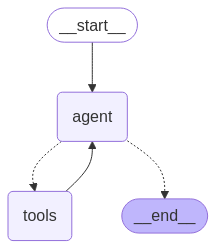

In [12]:
from IPython.display import Image, display

# Erstellen Sie den Agenten-Graphen
graph = agent_executor.get_graph()

# Zeichnen Sie den Graphen als PNG und zeigen Sie ihn an
display(Image(graph.draw_mermaid_png()))


## Probelauf Chatbot

Schließlich testen wir den Bot: Zunächst wird dafür eine Frage (`question`) definiert: *"Wie hoch waren die Drittmittel der FU Berlin im Jahr 2006 insgesamt?"*. Diese Frage wird später an den Agenten übergeben.

Dann wird eine Schleife (`for step in agent.stream(...)`) gestartet, die den Agenten Schritt für Schritt durch den Verarbeitungsprozess führt.  

- Der Agent erhält die Eingabe als eine Nachricht im Format `{"role": "user", "content": question}`.  
- Das Argument `stream_mode="values"` sorgt dafür, dass die Antwort in einzelnen Schritten ausgegeben wird.  
- Innerhalb der Schleife wird der jeweils letzte Schritt (`step["messages"][-1]`) formatiert und ausgegeben, sodass die Antwort für den Nutzer lesbar bleibt.  

Dadurch wird der Verarbeitungsweg der Antwort des Agenten schrittweise angezeigt.

In [32]:
# Testanfrage an den Agenten
question = "Wie viele Drittmittel von Stiftungen wurden 2020 in Deutschland ausgeschüttet?"

for step in agent_executor.stream(
    {"messages": [HumanMessage(content=question)]}, 
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Wie viele Drittmittel von Stiftungen wurden 2020 in Deutschland ausgeschüttet?
================================== Ai Message ==================================
Tool Calls:
  get_variable_id (call_wTxoquxgDH1LI4HmPh63bogF)
 Call ID: call_wTxoquxgDH1LI4HmPh63bogF
  Args:
    user_question: Drittmittel von Stiftungen ausgeschüttet 2020 in Deutschland
  get_reichweite_id (call_aQYqKx3eSvfJ87jXZpetk8L3)
 Call ID: call_aQYqKx3eSvfJ87jXZpetk8L3
  Args:
    user_question: Deutschland
ergebnisse retriever: Deutschland

Deutsch

Dänemark

Frankreich

Schweiz

Griechenland

Österreich

Niederlande

Spanien

Nordrhein-Westfalen

Vereinigtes Königreich

Baden-Württemberg

Thüringen

Nicht deutsch

Schweden
Drittmittel von Stiftungen

Drittmittel insgesamt

Drittmittel von Hochschulfördergesellschaften

Drittmittel von DFG-Einzelförderungen

Drittmittel der Länder (ohne Trägermittel)
SQL Query (Variable): SELECT id FRO

In [ ]:
# Testanfrage an den Agenten
question = "Wie viele Drittmittel von der EU hat Saarland 2020 eingeworben?"

for step in agent_executor.stream(
    {"messages": [HumanMessage(content=question)]}, 
    stream_mode="values"
):
    step["messages"][-1].pretty_print()


In [17]:


# Testanfrage an den Agenten
question = "Wie viele Studienanfänger ohne Abitur gab es an Universität 2019?"

for step in agent_executor.stream(
    {"messages": [HumanMessage(content=question)]}, 
    stream_mode="values"
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

Wie viele Studienanfänger ohne Abitur gab es an Universität 2019?
================================== Ai Message ==================================
Tool Calls:
  get_variable_id (call_kPdsQK1WcgtyX7jxvmNPUjWJ)
 Call ID: call_kPdsQK1WcgtyX7jxvmNPUjWJ
  Args:
    user_question: Studienanfänger ohne Abitur an Universität 2019
  get_reichweite_id (call_KykQ7csZDYJjVn5vVJOCI6jS)
 Call ID: call_KykQ7csZDYJjVn5vVJOCI6jS
  Args:
    user_question: Universität
Anzahl der Studienanfänger ohne Abitur

Anteil der Studienanfänger ohne Abitur

Studienabsolventen ohne Abitur

Anteil der Studienabsolventen ohne Abitur

Anzahl der Studienanfänger duales Studium
SQL Query (Variable): SELECT id FROM variable WHERE beschr = 'Anzahl der Studienanfänger ohne Abitur' LIMIT 1;
ergebnisse retriever: Universität

Universität Bielefeld

Universität der Bundeswehr

Universität Erfurt

Universität Konstanz

Universität Potsdam

Univer

In [ ]:
# IDs dynamisch abrufen
variable_id = db.run_no_throw("SELECT id FROM variable WHERE beschr = 'Anzahl der Studienanfänger ohne Abitur' LIMIT 1;")
reichweite_id = db.run_no_throw("SELECT id FROM reichweite WHERE beschr = '2019' LIMIT 1;")
werteinheit_id = db.run_no_throw("SELECT id FROM wert_einheit WHERE beschr = 'Anzahl' LIMIT 1;")

result = db.run_no_throw(
    """
    SELECT d.wert, d.zeit_start, d.zeit_ende
    FROM daten d
    LEFT JOIN daten_reichweite dr ON d.id = dr.daten_id
    LEFT JOIN reichweite r ON dr.reichweite_id = r.id
    WHERE d.variable_id = '123'
    AND r.id = '23'
    AND d.id = '8';

    """
)

In [ ]:
result